In [1]:
%pip install "pybamm[plot]" -q
%pip install ipywidgets -q

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
from typing import List, Dict
import json

def read_json_to_dict(file_path: str) -> List[str]:

    with open(file_path, 'r') as f:
        json_content = json.load(f)
    
    instructions = json_content.get('instructions', [])
    output_list = []

    type_to_units = {
     "ElectricCurrent": "A",
     "Voltage": "V",
     "power": "W",
     "resistance": "Ohm",
     "TimeDimension": "hour",
     "time": "sec",
     "CRate": "C",
     "emmo:Volt": "V",
     "emmo:Ampere": "A",
     "emmo:Second": "sec"
     }
    
    # Iterate through each instruction
    for instruction in instructions:
        sequence = instruction.get('sequence', [])
        sequence_output_list = []
        # Iterate through each step in the sequence
        for step in sequence:
            step_type = step.get('type', '')
            value = step.get('hasNumericalValue', '')
            unit = step.get('hasMeasurementUnit', '')
            termination = step.get('termination', [{}])[0]
            termination_type = termination.get('type', '')
            termination_value = termination.get('hasNumericalValue', '')
            termination_unit = termination.get('hasMeasurementUnit', '')

            # Check if value refers to a parameter
            if value in json_content['parameters']:
                value = json_content['parameters'][value]

            # Check if termination value refers to a parameter
            if termination_value in json_content['parameters']:
                termination_value = json_content['parameters'][termination_value]
            
            # Generate the instruction string
            if step_type.lower() == 'rest':
                time = step.get('hasNumericalValue', '')
                sequence_output_list.append(f"Rest for {time / 3600} {type_to_units.get('TimeDimension', 'hour')}")
            elif step_type == 'ElectricCurrent':
                if value > 0:
                    if termination_type == 'Voltage':
                        sequence_output_list.append(
                        f"Discharge at {value}{type_to_units.get(unit, unit)} "
                        f"until {termination_value}{type_to_units.get(termination_unit, termination_unit)}"
                        )
                    else:
                        sequence_output_list.append(
                        f"Discharge at {value}{type_to_units.get(unit, unit)} "
                        f"for {termination_value}{type_to_units.get(termination_unit, termination_unit)}"
                    )
                else:
                    if termination_type == 'Voltage':
                        sequence_output_list.append(
                        f"Charge at {-value}{type_to_units.get(unit, unit)} "
                        f"until {termination_value}{type_to_units.get(termination_unit, termination_unit)}"
                        )
                    else:
                        sequence_output_list.append(
                        f"Charge at {-value}{type_to_units.get(unit, unit)} "
                        f"for {termination_value}{type_to_units.get(termination_unit, termination_unit)}"
                        )
            elif step_type == 'Voltage':
                    if termination_type == 'ElectricCurrent':
                        sequence_output_list.append(
                        f"Hold at {value}{type_to_units.get(unit, unit)} "
                        f"until {termination_value}{type_to_units.get(termination_unit, termination_unit)}"
                        )
                    else:
                        sequence_output_list.append(
                        f"Hold at {value}{type_to_units.get(unit, unit)} "
                        f"for {termination_value}{type_to_units.get(termination_unit, termination_unit)}"
                        )
            else:
                sequence_output_list.append(
                    f"{type_to_units.get(step_type, step_type)} at {value}{type_to_units.get(unit, unit)} "
                    f"until {termination_value}{type_to_units.get(termination_unit, termination_unit)}"
                )
        if instruction.get('repeat', 1) > 1:
            for idx in range(instruction.get('repeat', 1)): # repetitions for sequences
                output_list.extend(sequence_output_list)
        else:
            output_list.extend(sequence_output_list)
            
    return output_list


Charge at 0.33C until 4.2V
Hold at 4.2V until 0.05A
Discharge at 0.5C until 3V
Charge at 0.5C until 4.2V
Hold at 4.2V until 0.05A
Rest for 1.0 hour
Discharge at 0.125C until 3V
Rest for 0.016666666666666666 hour
Charge at 0.5C for 640sec
Rest for 0.5 hour
Charge at 1C for 20sec
Rest for 0.016666666666666666 hour
Discharge at 1C for 20sec
Rest for 0.5 hour


In [9]:
read_json_to_dict("Examples/ShortCheckUp.json")

['Charge at 0.33C until 4.2V',
 'Hold at 4.2V until 0.05A',
 'Discharge at 0.5C until 3V',
 'Charge at 0.5C until 4.2V',
 'Hold at 4.2V until 0.05A',
 'Rest for 1.0 hour',
 'Discharge at 0.125C until 3V',
 'Rest for 0.016666666666666666 hour',
 'Charge at 0.5C for 640sec',
 'Rest for 0.5 hour',
 'Charge at 1C for 20sec',
 'Rest for 0.016666666666666666 hour',
 'Discharge at 1C for 20sec',
 'Rest for 0.5 hour']

In [5]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

experiment = pybamm.Experiment(read_json_to_dict("Examples/ShortCheckUp.json"))

model = pybamm.lithium_ion.SPM()
#model = pybamm.equivalent_circuit.Thevenin()
sim = pybamm.Simulation(model, experiment=experiment)
sol = sim.solve()


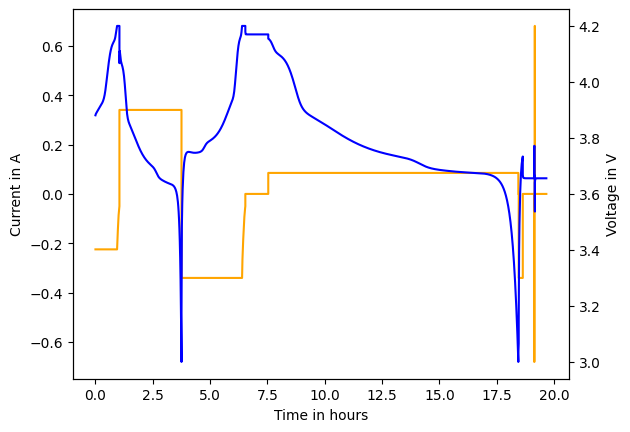

In [6]:
voltage = sol["Voltage [V]"].entries
time = sol["Time [h]"].entries
current = sol["Current [A]"].entries

plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
ax.plot(time,current,label="current",color='orange')
ax2.plot(time,voltage,label="voltage",color='blue')
ax.set_ylabel("Current in A")
ax2.set_ylabel("Voltage in V")
ax.set_xlabel("Time in hours")
plt.show()


In [ ]:
# Convert to BatteryDynamics

import json

def convert_to_cycler_format(input_file, output_file):
    # Load the input JSON file
    with open(input_file, 'r') as file:
        data = json.load(file)

    # Initialize the structure for the cycler format
    cycler_data = {
        "version": 2.1,
        "globals": [],
        "steps": []
    }

    # Default units mapping (you might need to adjust this based on actual requirements)
    default_units = {
        "current": "A",
        "voltage": "V",
        "time": "s",
        "resistance": "Ohm",
        "power": "W",
        "temperature": "degC"
    }

    # Process parameters and add to globals
    for param, value in data.get("parameters", {}).items():
        unit = default_units.get(param.lower(), "")  # Get the unit from the default mapping
        cycler_data["globals"].append({
            "name": param.upper(),
            "value": str(value),
            "unit": unit
        })

    # Process instructions and convert them to steps
    for instruction in data.get("instructions", []):
        for seq in instruction.get("sequence", []):
            step_type = seq.get("type").upper()  # Assuming the type is directly mappable
            step_id = f"{step_type}_{instruction['name']}_{seq.get('id', '')}"

            # Create a step with basic structure
            step = {
                "id": step_id,
                "type": "SECTION",  # You may need specific logic to determine the correct type
                "title": f"{instruction['name']} - Step {seq.get('id', '')}",
                "description": "Auto-generated step",
                "steps": []  # Sub-steps need to be added based on the sequence content
            }

            

            # You might need specific handling for different types of sequences
            # For example, if sequence type is 'CHARGE', 'DISCHARGE', etc.
            # This is a placeholder for that logic

            cycler_data["steps"].append(step)

    # Save the converted data to the output file
    with open(output_file, 'w') as file:
        json.dump(cycler_data, file, indent=2)

# Example usage
convert_to_cycler_format('input_file.json', 'output_file.json')


In [13]:
import json

def map_sequence_to_cycler_format(sequence):
    """
    Map a sequence from the input format to the battery cycler format.
    """
    cycler_sequence = {}

    

    if sequence['type'] == 'Rest' or sequence['type'] == 'Pause':
        # Handle PAUSE sequence
        cycler_sequence = {
            "type": "PAUSE",
            "duration": sequence.get("duration", 1),  # Default 1 hour
            "unit": "h"

            
        }


    elif sequence['type'] == 'CHARGE_CC':
        # Handle CHARGE_CC sequence
        cycler_sequence = {
            "type": "CHARGE",
            "mode": "CC",
            "current": sequence.get("current", 0.5),  # Default 0.5 A
            "unit": "A"
        }

    elif sequence['type'] == 'CHARGE_CV':
        # Handle CHARGE_CV sequence
        cycler_sequence = {
            "type": "CHARGE",
            "mode": "CV",
            "voltage": sequence.get("voltage", 4.2),  # Default 4.2 V
            "unit": "V"
        }

    elif sequence['type'] == 'DISCHARGE_CC':
        # Handle DISCHARGE_CC sequence
        cycler_sequence = {
            "type": "DISCHARGE",
            "mode": "CC",
            "current": sequence.get("current", 0.5),  # Default 0.5 A
            "unit": "A"
        }

    elif sequence['type'] == 'SET_VARIABLES':
        # Handle SET_VARIABLES sequence
        cycler_sequence = {
            "type": "SET_VARIABLES",
            "variable": sequence.get("variable"),
            "value": sequence.get("value")
        }

    elif sequence['type'] == 'LOOP_START':
        # Handle LOOP_START sequence
        cycler_sequence = {
            "type": "LOOP_START",
            "count": sequence.get("count", 1)  # Default 1 loop
        }

    elif sequence['type'] == 'LOOP_END':
        # Handle LOOP_END sequence
        cycler_sequence = {
            "type": "LOOP_END"
        }

    elif sequence['type'] == 'SECTION':
        # Handle SECTION sequence
        cycler_sequence = {
            "type": "SECTION",
            "title": sequence.get("title", "Unnamed Section"),
            "description": sequence.get("description", "")
        }

    # Add more specific cases as needed
    return cycler_sequence

def map_step_to_operation(sequence):
    """
    Map a step from the input JSON to a specific operation (Charge, Discharge, etc.).
    """
    operation = {}

    if sequence['type'] == 'ElectricCurrent':
        if sequence.get('value', 0) > 0:
            # If current value is positive, consider it as a charge operation
            operation['type'] = 'CHARGE_CC'
            operation['current'] = sequence['value']
        else:
            # If current value is negative or zero, consider it as a discharge operation
            operation['type'] = 'DISCHARGE_CC'
            operation['current'] = -sequence['value']  # Assuming value is negative for discharge

    elif sequence['type'] == 'Voltage':
        # Assuming voltage control relates to a constant voltage charge operation
        operation['type'] = 'CHARGE_CV'
        operation['voltage'] = sequence['value']

    elif sequence['type'] == 'Rest' or sequence['type'] == 'Pause':
        operation['type'] = 'REST'
        operation['duration'] = sequence.get('duration', 1)  # Default to 1 hour

    elif sequence['type'] == 'Cycle':
        operation['type'] = 'CYCLE'
        operation['count'] = sequence.get('count', 1)  # Default to 1 cycle

    # Add common attributes such as unit and termination conditions if available
    operation['unit'] = sequence.get('unit', 'X')  # Default unit
    # Add termination conditions logic here if applicable

    return operation

def convert_to_cycler_format(input_file, output_file):
    # Load the input JSON file
    with open(input_file, 'r') as file:
        data = json.load(file)

    # Initialize the structure for the cycler format
    cycler_data = {
        "version": 2.1,
        "steps": []
    }

    # Process each instruction and map it to the cycler format
    for instruction in data.get("instructions", []):
        for seq in instruction.get("sequence", []):
            #operation = map_step_to_operation(seq)
            cycler_seq = map_sequence_to_cycler_format(seq)
            cycler_data["steps"].append(cycler_seq)

    # Save the converted data to the output file
    with open(output_file, 'w') as file:
        json.dump(cycler_data, file, indent=2)





# Example usage
convert_to_cycler_format('Examples/CellConditioningDubarry2020.json', 'output_file.json')